# Kalman Filter - 1D example - Inferred Velocity

This notebook illustrates the 1D Kalman filter where the speed is inferred from the location observations rather than provided explicitly. Additionally, this filter is extended to account for the control element - acceleration. The acceleration can be added directly to the calculation by adjusting the $F$ matrix and $x$ vector.

In [1]:
import numpy as np

## Predict step

The prediction step remains unchanged. However, the velocity and acceleration elements are infered by the Kalaman filter.:

$x_{t}$ = F * $x_{t-1}$

The transition matrix $F$:
$$
F = \left(\begin{array}{cc}
x & \Delta t & 0.5*\Delta t^{2}\\
0.0 & v & \Delta t\\
0.0 & 0.0 & a
\end{array}\right)
->
\left(\begin{array}{cc}
1.0 & \Delta t & 0.5*\Delta t^{2}\\
0.0 & 1.0 & \Delta t\\
0.0 & 0.0 & 1.0
\end{array}\right)
$$

State $x$:

$$
x = \left(\begin{array}{cc} 
x \\ 
v \\ 
a 
\end{array}\right)
$$

Example:

In [2]:
t = 1.0
F = np.matrix([
    [1., t, 0.5*t*t],
    [0., 1., t],
    [0., 0., 1.]
])

## Update step


### Error calculation

The update step takes observations $(z)$ and calculate the error $(y)$.
$$
z = x_{meas} \\
 \\
y = z - x_{t}
$$

However, observation $z$ now contains only one elemnet - location, whereas the prediction contains location $(x)$, velocity $(v)$, and acceleration $a$. Therefore, to bring $x$ to the $z$ format we use observation matrix $H$:
$$
H = \left(\begin{array}{cc} x & v & a\end{array}\right) =  \left(\begin{array}{cc} 1.0 & .0 & .0\end{array}\right)
 \\
y = z - H*x_{t}
$$

In [3]:
H = np.matrix([1.0, 0.0, 0.0])

## Example

Set initial assumptions:

- x0 - current location assumption
- v0 - current speed / velocity assumption
- x_var0 - confidence in the initial location assumpiton - no impact on Kalman filter as long as initial value is high
- v_var0 - confidence in the initial speed / velocity assumpiton - no impact on Kalman filter as long as initial value is high
- x_measErr - location measurement noise

In [4]:
x0 = 0.0
v0 = 0.0
a0 = 0.0
x_var0 = 100.0
v_var0 = 100.0
a_var0 = 100.0
x_measErr = 10.0

In [5]:
from observations import Observations
from covariance import CovarianceEstimator
from visualization import plot_results

In [6]:
o = Observations(start=100.0, decay=0.99, noise_x=x_measErr)
covar = CovarianceEstimator(n_dim=H.shape[0], dtype=H.dtype)
I = np.identity(F.shape[0], dtype=F.dtype)

In [7]:
x_t0 = np.matrix([x0, v0, a0]).T
R = np.matrix(np.array([100*x_measErr**2,]))
P = np.matrix(np.diag(np.array([x_var0, v_var0, a_var0])))

In [8]:
results = dict(
    predictions = list(),
    pred_std = list(),
    observations = list(),
)

for _ in range(100):

        # prediction step
        x_t1 = F * x_t0

        # update
        # - error
        z = np.matrix([o.get()[0],]).T
        y = z - H*x_t1

        # - Kalman gain
        # K = P / (P+R)
        S = H*P*H.T + R
        K = P*H.T * np.linalg.inv(S)

        # - state update
        # x[t] = x[t|t-1] * K*y
        x_t0 = x_t1 + K*y

        # - prediction error update
        # P = (1-K)*P
        P = (I - K*H)*P
        # P = P + Q
        Q = covar.eval(y)
        P = F*P*F.T + H.T*Q*H
        results['predictions'].append([
            float(x_t0[0,0]), float(x_t0[1,0]), float(x_t0[2,0])
            # float(x_t1[0,0]), float(x_t1[1,0]), float(x_t1[2,0])
        ])
        results['pred_std'].append(float(np.sqrt(P[0,0])))
        results['observations'].append(float(z[0,0]))

### Plot 1 - Observations vs Predicitons

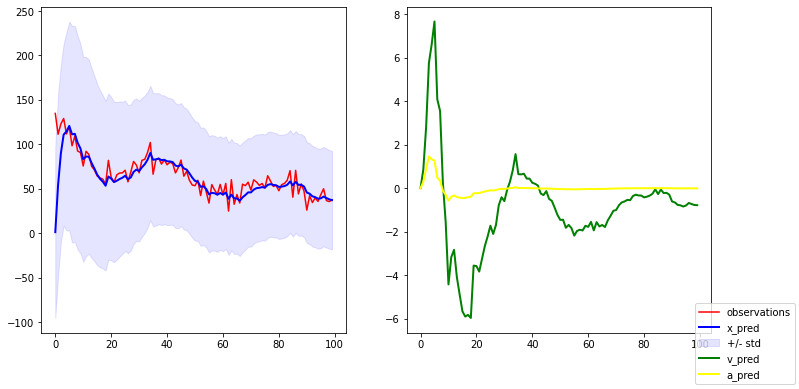

In [9]:
plot_results(**results, file_name=None)